In [188]:
import os
import cv2 as cv2
import numpy as np
from time import time
import matplotlib.pyplot as plt
import matplotlib
from enum import Enum

In [202]:
DIR = 'images'
images = []
for file in os.listdir(DIR):
    image = cv2.imread(DIR + "/" + file)
    images.append(image)

In [203]:
def get_harris_corners(image):
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grey_image = cv2.GaussianBlur(grey_image, (7, 7), 0)
    grey_image = np.float32(grey_image)
    dst = cv2.cornerHarris(grey_image, 4, 5, 0.04)
    dst = cv2.dilate(dst, None)
    kps = (dst > 0.01 * dst.max()).nonzero()
    return np.transpose(dst[kps]), len(np.transpose(kps))

def get_sift_features(image):
    descriptor = cv2.SIFT_create()
    (kps, features) = descriptor.detectAndCompute(image, None)
    return features, len(kps)

def get_orb_features(image):
    descriptor = cv2.ORB_create()
    (kps, features) = descriptor.detectAndCompute(image, None)
    return features, len(kps)

In [204]:
def get_images_features(images, method):
    images_features = [] 
    all_kps_len = 0
    for image in images:
        features, kps_len = method(image)
        images_features.append(features)
        all_kps_len += kps_len
    return images_features, all_kps_len

In [205]:
class Names(str, Enum):
    HARRIS = 'HARRIS',
    ORB = 'ORB',
    SIFT = 'SIFT',

    def __str__(self) -> str:
        return self.value
    
    @classmethod
    def list(cls):
        return list(map(lambda c: c.value, cls))

Среднее время HARRIS: 0.141 mcs/pt
Среднее время ORB: 6.937 mcs/pt
Среднее время SIFT: 27.541 mcs/pt


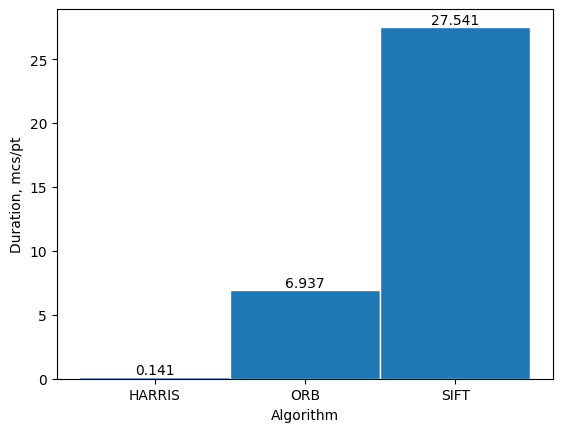

In [206]:
algorithms_dict = {
    Names.HARRIS: get_harris_corners,
    Names.ORB: get_orb_features,
    Names.SIFT: get_sift_features,
}

features_dict = {}
duration_dict = {}

for label, algorithm in algorithms_dict.items():
    start = time()
    features, kps_len = get_images_features(images, algorithm)
    end = time()

    features_dict[label] = features
    duration_dict[label] = np.round((end - start) / kps_len * 10**6, 3)

    print(f'Среднее время {label}: {duration_dict[label]} mcs/pt')

fig, ax = plt.subplots() 
bars = ax.bar(duration_dict.keys(), duration_dict.values(), width=1, edgecolor="white")
ax.bar_label(bars)

plt.xlabel("Algorithm")
plt.ylabel("Duration, mсs/pt")
None


In [207]:
def get_repeatability(features_coll, norm=cv2.NORM_L2):   
    bruteforce = cv2.BFMatcher(norm, crossCheck=True)
    repeatabilities = []
    for i, i_features in enumerate(features_coll):
        repeats_count = np.zeros(len(i_features))
        for j, j_features in enumerate(features_coll):
            if i != j:
                matches = bruteforce.match(i_features, j_features)
                for match in matches:
                    repeats_count[match.queryIdx] += 1
        repeatability = (repeats_count / (len(features_coll) - 1)).mean()
        repeatabilities.append(repeatability)
    return repeatabilities

In [208]:
repeatabilities_dict = {}

for label, features in features_dict.items():
    repeatabilities = get_repeatability(features)
    repeatabilities_dict[label] = repeatabilities

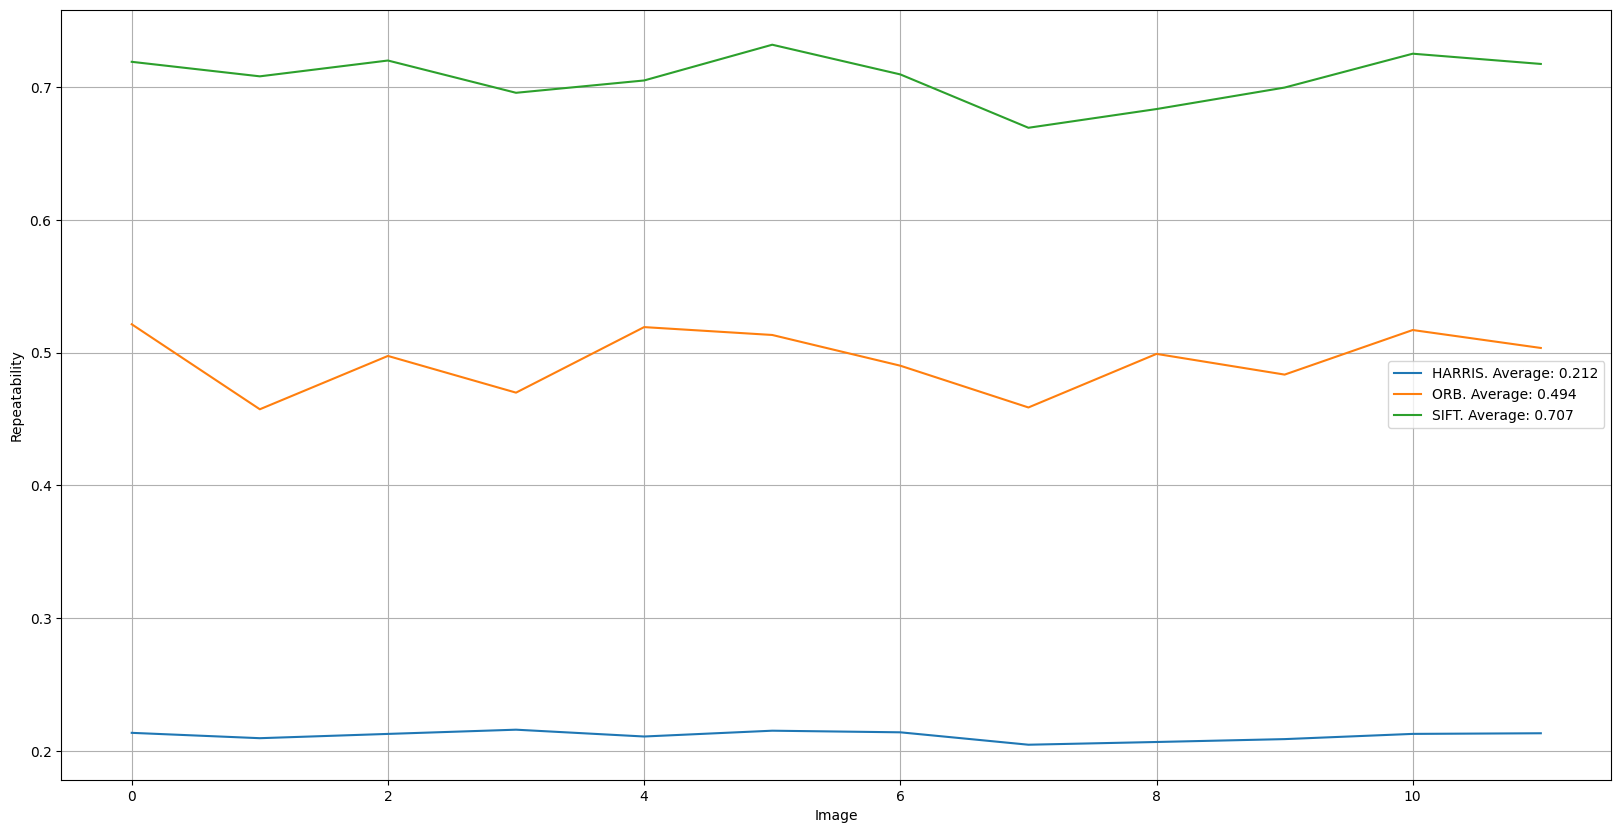

In [209]:
plt.figure(figsize=(20, 10))
plt.xlabel("Image")
plt.ylabel("Repeatability")
plt.grid()

for label, repeatabilities in repeatabilities_dict.items():
    average = np.round(np.average(repeatabilities), 3)
    plt.plot(repeatabilities, label=f'{label}. Average: {average}')

plt.legend()
plt.show()

### Вывод

Были рассмотрены три типа детекторов HARRIS, ORB, SIFT.

**Воспроизводимость**
| **Detector** | **Average repeatability** |
|----------|-------------------|
| HARRIS   | 0.212             |
| ORB      | 0.494            |
| SIFT     | 0.707            |

**Скорость**
| **Detector** | **Speed, mcs/pt** |
|----------|-------------------|
| HARRIS   | 0.141             |
| ORB      | 6.397             |
| SIFT     | 27.541            |

По полученным данных видим, что в плане воспроизводимости лучше все работает детектор SIFT, а хуже всех HARRIS. При этом в плане скорости работы картина в точности обратная.
